In [ ]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import statsmodels.api as sm
from datetime import date, datetime
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## CAPM - Un solo fattore

Lewinson (2020) Python for Finance Cookbook - cap. 4

### Calcolo del beta vs mercato azionario

In [ ]:
risky_asset = 'AMZN' # Amazon
market_benchmark = '^GSPC' # S&P 500
start_date = '2014-01-01'
end_date = '2021-11-30'

In [ ]:
df = web.get_data_yahoo([risky_asset, market_benchmark],
                       start = start_date, end = end_date)

/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'AMZN', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: '^GSPC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


RemoteDataError: ignored

In [ ]:
df.head()

Attributes   Adj Close                    Close                     High  \
Symbols           AMZN        ^GSPC        AMZN        ^GSPC        AMZN   
Date                                                                       
2014-01-02  397.970001  1831.979980  397.970001  1831.979980  399.359985   
2014-01-03  396.440002  1831.369995  396.440002  1831.369995  402.709991   
2014-01-06  393.630005  1826.770020  393.630005  1826.770020  397.000000   
2014-01-07  398.029999  1837.880005  398.029999  1837.880005  398.470001   
2014-01-08  401.920013  1837.489990  401.920013  1837.489990  403.000000   

Attributes                      Low                     Open               \
Symbols           ^GSPC        AMZN        ^GSPC        AMZN        ^GSPC   
Date                                                                        
2014-01-02  1845.859985  394.019989  1827.739990  398.799988  1845.859985   
2014-01-03  1838.239990  396.220001  1829.130005  398.290009  1833.209961   
2014-01-06  1837.160034  388.420013  1823.729980  395.850006  1832.310059   
2014-01-07  1840.099976  394.290009  1828.709961  395.040009  1828.709961   
2014-01-08  1840.020020  396.040009  1831.400024  398.470001  1837.900024   

Attributes   Volume              
Symbols        AMZN       ^GSPC  
Date                             
2014-01-02  2137800  3080600000  
2014-01-03  2210200  2774270000  
2014-01-06  3170600  3294850000  
2014-01-07  1916000  3511750000  
2014-01-08  2316500  3652140000

In [ ]:
X = df['Adj Close'].rename(columns={risky_asset:'asset', market_benchmark:'market'})\
.resample('M').last().pct_change().dropna()


In [ ]:
X.head()

Symbols,asset,market
Date,,
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030
2014-06-30,0.039130,0.019058


In [ ]:
X.cov()

Symbols,asset,market
Symbols,,
asset,0.006705,0.001870
market,0.001870,0.001587


In [ ]:
covariance = X.cov().iloc[0,1]

In [ ]:
benchmark_variance = X.market.var()

In [ ]:
X.market.var()

0.0015872028140674547

In [ ]:
beta = covariance / benchmark_variance
beta

1.1784544524553286

### CAPM - 1 solo fattore

In [ ]:
y = X.pop('asset')
y

Date
2014-02-28    0.009507
2014-03-31   -0.071058
2014-04-30   -0.095847
2014-05-31    0.027685
2014-06-30    0.039130
                ...   
2021-07-31   -0.032722
2021-08-31    0.043034
2021-09-30   -0.053518
2021-10-31    0.026602
2021-11-30    0.061671
Freq: M, Name: asset, Length: 94, dtype: float64

In [ ]:

X = sm.add_constant(X)
X

,const,market
Date,,
2014-02-28,1.0,0.043117
2014-03-31,1.0,0.006932
2014-04-30,1.0,0.006201
2014-05-31,1.0,0.021030
2014-06-30,1.0,0.019058
...,...,...
2021-07-31,1.0,0.022748
2021-08-31,1.0,0.028990
2021-09-30,1.0,-0.047569


In [ ]:
capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     45.06
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           1.54e-09
Time:                        14:06:14   Log-Likelihood:                 121.09
No. Observations:                  94   AIC:                            -238.2
Df Residuals:                      92   BIC:                            -233.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0148      0.007      2.050      0.0

#### Inseriamo il risk free

In [ ]:
risk_free = '^IRX'

In [ ]:
df = web.get_data_yahoo([risky_asset, market_benchmark, risk_free],
                       start = start_date, end = end_date)

In [ ]:
df.head()

Attributes   Adj Close                           Close                      \
Symbols           AMZN        ^GSPC   ^IRX        AMZN        ^GSPC   ^IRX   
Date                                                                         
2014-01-02  397.970001  1831.979980  0.058  397.970001  1831.979980  0.058   
2014-01-03  396.440002  1831.369995  0.058  396.440002  1831.369995  0.058   
2014-01-06  393.630005  1826.770020  0.045  393.630005  1826.770020  0.045   
2014-01-07  398.029999  1837.880005  0.043  398.029999  1837.880005  0.043   
2014-01-08  401.920013  1837.489990  0.040  401.920013  1837.489990  0.040   

Attributes        High                             Low                      \
Symbols           AMZN        ^GSPC   ^IRX        AMZN        ^GSPC   ^IRX   
Date                                                                         
2014-01-02  399.359985  1845.859985  0.060  394.019989  1827.739990  0.055   
2014-01-03  402.709991  1838.239990  0.060  396.220001  1829.130005  0.058   
2014-01-06  397.000000  1837.160034  0.055  388.420013  1823.729980  0.045   
2014-01-07  398.470001  1840.099976  0.048  394.290009  1828.709961  0.040   
2014-01-08  403.000000  1840.020020  0.043  396.040009  1831.400024  0.035   

Attributes        Open                         Volume                     
Symbols           AMZN        ^GSPC   ^IRX       AMZN         ^GSPC ^IRX  
Date                                                                      
2014-01-02  398.799988  1845.859985  0.060  2137800.0  3.080600e+09  0.0  
2014-01-03  398.290009  1833.209961  0.060  2210200.0  2.774270e+09  0.0  
2014-01-06  395.850006  1832.310059  0.055  3170600.0  3.294850e+09  0.0  
2014-01-07  395.040009  1828.709961  0.048  1916000.0  3.511750e+09  0.0  
2014-01-08  398.470001  1837.900024  0.037  2316500.0  3.652140e+09  0.0

In [ ]:
X1 = df['Adj Close'].rename(columns={risky_asset:'asset', market_benchmark:'market', risk_free: 'risk_free'})


In [ ]:
X1.head()

Symbols,asset,market,risk_free
Date,,,
2014-01-02,397.970001,1831.979980,0.058
2014-01-03,396.440002,1831.369995,0.058
2014-01-06,393.630005,1826.770020,0.045
2014-01-07,398.029999,1837.880005,0.043
2014-01-08,401.920013,1837.489990,0.040


In [ ]:
X1 = X1.resample('M').last()
X1

Symbols,asset,market,risk_free
Date,,,
2014-01-31,358.690002,1782.589966,0.010
2014-02-28,362.100006,1859.449951,0.043
2014-03-31,336.369995,1872.339966,0.028
2014-04-30,304.130005,1883.949951,0.020
2014-05-31,312.549988,1923.569946,0.030
...,...,...,...
2021-07-31,3327.590088,4395.259766,0.040
2021-08-31,3470.790039,4522.680176,0.040
2021-09-30,3285.040039,4307.540039,0.028


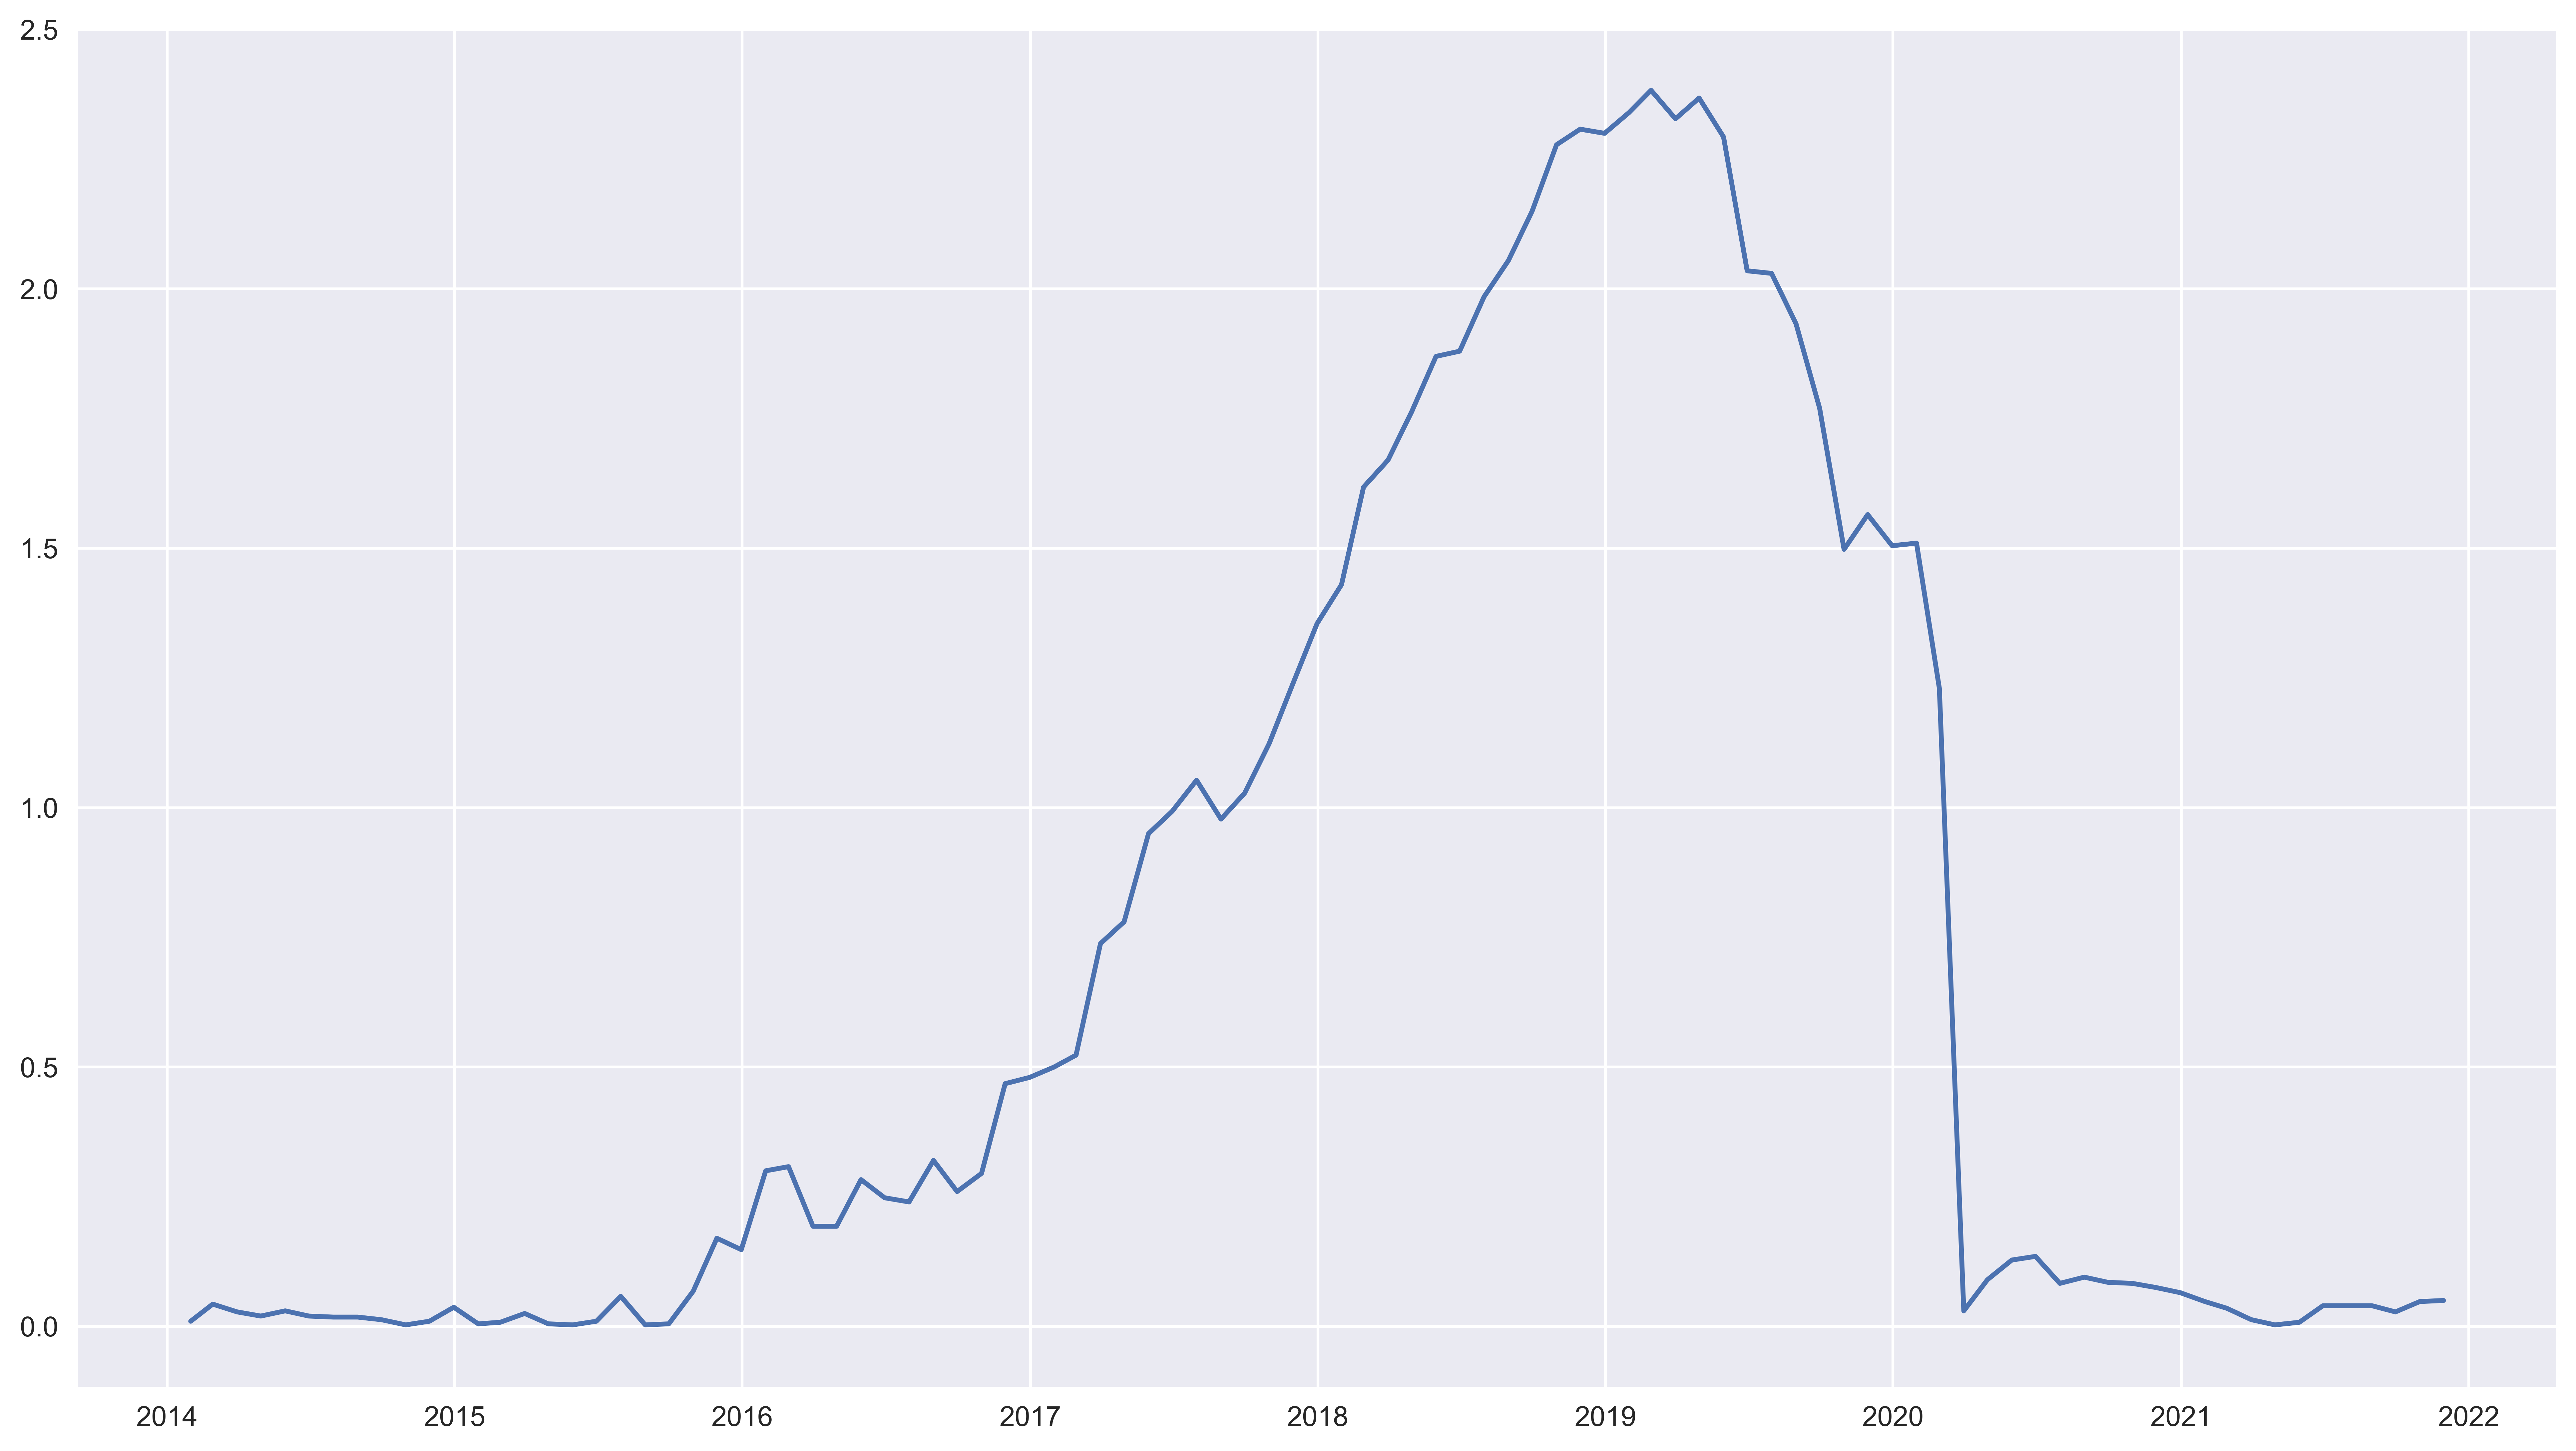

In [ ]:
plt.plot(X1['risk_free'])

In [ ]:
X1['mrf'] = (1 + X1['risk_free'])**(30/360) - 1

In [ ]:
X1[50:70]

Symbols,asset,market,risk_free,mrf
Date,,,,
2018-03-31,1447.339966,2640.870117,1.670,0.085282
2018-04-30,1566.130005,2648.050049,1.763,0.088383
2018-05-31,1629.619995,2705.270020,1.870,0.091835
2018-06-30,1699.800049,2718.370117,1.880,0.092151
2018-07-31,1777.439941,2816.290039,1.985,0.095415
2018-08-31,2012.709961,2901.520020,2.055,0.097533
2018-09-30,2003.000000,2913.979980,2.150,0.100337
2018-10-31,1598.010010,2711.739990,2.278,0.103996
2018-11-30,1690.170044,2760.169922,2.308,0.104834


In [ ]:
X1['asset_nmr'] = X1['asset'].pct_change() - X1['mrf']

In [ ]:
X1['market_nmr'] = X1['market'].pct_change() - X1['mrf']

In [ ]:
X1.head()

Symbols,asset,market,risk_free,mrf,asset_nmr,market_nmr
Date,,,,,,
2014-01-31,358.690002,1782.589966,0.010,0.000830,NaN,NaN
2014-02-28,362.100006,1859.449951,0.043,0.003515,0.005992,0.039602
2014-03-31,336.369995,1872.339966,0.028,0.002304,-0.073362,0.004628
2014-04-30,304.130005,1883.949951,0.020,0.001652,-0.097498,0.004549
2014-05-31,312.549988,1923.569946,0.030,0.002466,0.025219,0.018564


In [ ]:
X1.tail()

Symbols,asset,market,risk_free,mrf,asset_nmr,market_nmr
Date,,,,,,
2021-07-31,3327.590088,4395.259766,0.040,0.003274,-0.035996,0.019474
2021-08-31,3470.790039,4522.680176,0.040,0.003274,0.039760,0.025717
2021-09-30,3285.040039,4307.540039,0.028,0.002304,-0.055822,-0.049873
2021-10-31,3372.429932,4605.379883,0.048,0.003915,0.022688,0.065229
2021-11-30,3580.409912,4701.459961,0.050,0.004074,0.057597,0.016788


In [ ]:
X1.dropna(inplace=True)

In [ ]:
X1.head()

Symbols,asset,market,risk_free,mrf,asset_nmr,market_nmr
Date,,,,,,
2014-02-28,362.100006,1859.449951,0.043,0.003515,0.005992,0.039602
2014-03-31,336.369995,1872.339966,0.028,0.002304,-0.073362,0.004628
2014-04-30,304.130005,1883.949951,0.020,0.001652,-0.097498,0.004549
2014-05-31,312.549988,1923.569946,0.030,0.002466,0.025219,0.018564
2014-06-30,324.779999,1960.229980,0.020,0.001652,0.037478,0.017407


In [ ]:
X2 = X1[['asset_nmr', 'market_nmr']]

In [ ]:
X2.head()

Symbols,asset_nmr,market_nmr
Date,,
2014-02-28,0.005992,0.039602
2014-03-31,-0.073362,0.004628
2014-04-30,-0.097498,0.004549
2014-05-31,0.025219,0.018564
2014-06-30,0.037478,0.017407


In [ ]:
y = X2.pop('asset_nmr')

NameError: ignored

In [ ]:
X = sm.add_constant(X2)
X

NameError: ignored

In [ ]:
capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:              asset_nmr   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     82.52
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           1.93e-14
Time:                        14:17:07   Log-Likelihood:                 120.89
No. Observations:                  94   AIC:                            -237.8
Df Residuals:                      92   BIC:                            -232.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.008      2.529      0.0

### Il modello di Fama - French a tre fattori

I tre fattori del modello di Fama e French (*) sono:
- il fattore mercato, cioè la dipendenza dall'andamento del mercato azionario  (MKT)
- il fattore dimensione (SMB) costruito come rendimento in eccesso delle azioni a piccola capitalizzazione rispetto alle grandi
- il fattore valore (HML) costruito come rendimento in eccesso delle azioni con un rapporto fra patrimonio e prezzo alto (Value stocks) e quelle con un rapporto fra patriomonio e prezzo basso (Growth stocks)

I dati vanno scaricati da questo sito

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

(Fama, E.F. - French, K.R. (1993) "Common risk factors in the returns on stocks and bonds" Journal of Financial Economics, 33 (1) 

In [ ]:
factor_df = pd.read_csv('F-F_Data_Factors.csv', skiprows=3)

In [ ]:
factor_df.head()

Definiamo i parametri

In [ ]:
risky_asset = 'X' #azione da analizzare con i fattori di rischio
start_date = '2013-12-31'
end_date = '2021-10-31'

Eliminiamo i dati annuali in fondo al file

In [ ]:
stringa = ' Annual Factors: January-December '
indices = factor_df.iloc[:,0] == stringa
start_of_annual = factor_df[indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual]

Rinominiamo le colonne, definiamo come indice la data, filtriamo l'intervallo che ci interessa, dividiamo tutto per 100

In [ ]:
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']

In [ ]:
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

In [ ]:
factor_df.head()

In [ ]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[start_date:end_date]

In [ ]:
factor_df.head()

In [ ]:
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

In [ ]:
factor_df.head()

Scarichiamo i prezzi dell'azione e calcoliamo i rendimenti mensili

In [ ]:
asset_df = web.get_data_yahoo(risky_asset, start_date, end_date) 

In [ ]:
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()

In [ ]:
y.index = y.index.strftime('%Y-%m')

In [ ]:
y.name = 'rtn'

In [ ]:
y.head()

Uniamo i due df e calcoliamo i rendimenti in eccesso rispetto al rf dell'azione

In [ ]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

In [ ]:
ff_data.head()

Stimiamo il modello a tre fattori

In [ ]:
import statsmodels.formula.api as smf
ff_model = smf.ols(formula = 'excess_rtn ~ mkt + smb + hml', data = ff_data).fit()
print(ff_model.summary())

#### Modello Fama French a tre fattori rolling su un portafoglio

Parametri

In [ ]:
assets = ['JPM','X','JNJ','CSCO']
weights = [0.25, 0.25, 0.25, 0.25]
start_date = '2009-12-31'
end_date = '2021-10-31'

Carichiamo i dati di Fama French in un altro modo

In [ ]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = start_date)[0]

In [ ]:
df_three_factor.head()

In [ ]:
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

In [ ]:
df_three_factor.head()

Carichiamo i prezzi delle quattro azioni 

In [ ]:
asset_df = web.get_data_yahoo(assets, start_date, end_date) 

In [ ]:
asset_df = asset_df['Adj Close'].resample('M').last().pct_change().dropna()

In [ ]:
asset_df.index = asset_df.index.strftime('%Y-%m')
asset_df.head()

Calcoliamo i rendimenti del portafoglio

In [ ]:
asset_df['portfolio_returns'] = np.matmul(asset_df[assets].values, weights)

In [ ]:
asset_df.head()

In [ ]:
asset_df.plot(figsize=(16,9), grid = True);

Uniamo i due df

In [ ]:
ff_data = asset_df.join(df_three_factor).drop(assets, axis = 1)

In [ ]:
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [ ]:
ff_data.head()

Creiamo una funzione per calcolare la regressione ricorrente

In [ ]:
def rolling_factor_model(input_data, formula, window_size):
    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:])

    return coeffs_df

In [ ]:
model_formula = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, model_formula, window_size = 60)

In [ ]:
results_df.plot(title = 'Rolling Fama-French Three Factor model');

### Modelo di Carhart a quattro fattori e Fama e French a cinque fattori

In [ ]:
risky_asset = 'AMZN'
start_date = '2013-12-31'
end_date = '2021-10-31'

In [ ]:
# tre fattori
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = start_date)[0]
df_three_factor.index = df_three_factor.index.format()

In [ ]:
# quattro fattori con fattore "momentum" di Carhart
df_mom = web.DataReader('F-F_Momentum_factor', 'famafrench', start = start_date)[0]
df_mom.index = df_mom.index.format()

In [ ]:
# cinque fattori con fattori Robust Minus Weak (RMW) e Conservative Minus Aggressive (CMA)
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start_date)[0]
df_five_factor.index = df_five_factor.index.format()

In [ ]:
asset_df = web.get_data_yahoo(risky_asset,
                       start = start_date, end = end_date)

In [ ]:
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
y.index = y.index.strftime('%Y-%m')
y.name = 'return'

In [ ]:
y

Date
2014-01   -0.100554
2014-02    0.009507
2014-03   -0.071058
2014-04   -0.095847
2014-05    0.027685
             ...   
2021-06    0.067355
2021-07   -0.032722
2021-08    0.043034
2021-09   -0.053518
2021-10    0.026602
Name: return, Length: 94, dtype: float64

In [ ]:
four_factor_data = df_three_factor.join(df_mom).join(y)

In [ ]:
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

In [ ]:
four_factor_data.loc[:,four_factor_data.columns != 'rtn'] /= 100

In [ ]:
#four_factor_data.index = pd.to_datetime(four_factor_data.index, format = '%Y-%m')
four_factor_data.dropna(inplace = True)

In [ ]:
four_factor_data = four_factor_data.loc[start_date:end_date]

In [ ]:
four_factor_data['excess_rtn'] = four_factor_data['rtn'] - four_factor_data['rf']

In [ ]:
four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01,-0.0332,0.0092,-0.0202,0.0,0.0171,-0.100554,-0.100554
2014-02,0.0465,0.0037,-0.0031,0.0,0.0207,0.009507,0.009507
2014-03,0.0043,-0.0187,0.0492,0.0,-0.0329,-0.071058,-0.071058
2014-04,-0.0019,-0.0420,0.0114,0.0,-0.0389,-0.095847,-0.095847
2014-05,0.0206,-0.0189,-0.0013,0.0,0.0088,0.027685,0.027685


In [ ]:
four_factor_model = smf.ols(formula ='excess_rtn ~ mkt + smb + hml + mom', data = four_factor_data).fit()

In [ ]:
print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     22.98
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           4.59e-13
Time:                        15:56:53   Log-Likelihood:                 134.53
No. Observations:                  94   AIC:                            -259.1
Df Residuals:                      89   BIC:                            -246.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0057      0.006      0.875      0.3

In [ ]:
five_factor_data = df_five_factor.join(y)

In [ ]:
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

In [ ]:
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

In [ ]:
#five_factor_data.index = pd.to_datetime(five_factor_data.index, format = '%Y-%m')

In [ ]:
five_factor_data.dropna(inplace = True)

In [ ]:
five_factor_data = five_factor_data.loc[start_date:end_date]

In [ ]:
five_factor_data['excess_rtn'] = five_factor_data['rtn'] - five_factor_data['rf']

<ipython-input-209-4ddd14492285>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_factor_data['excess_rtn'] = five_factor_data['rtn'] - five_factor_data['rf']


In [ ]:
five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01,-0.0332,0.0059,-0.0202,-0.0388,-0.0143,0.0,-0.100554,-0.100554
2014-02,0.0465,0.0016,-0.0031,-0.0023,-0.0048,0.0,0.009507,0.009507
2014-03,0.0043,-0.0113,0.0492,0.0211,0.0198,0.0,-0.071058,-0.071058
2014-04,-0.0019,-0.0413,0.0114,0.0345,0.0103,0.0,-0.095847,-0.095847
2014-05,0.0206,-0.0189,-0.0013,0.0005,-0.0101,0.0,0.027685,0.027685


In [ ]:
five_factor_model = smf.ols(formula ='excess_rtn ~ mkt + smb + hml + rmw + cma', data = five_factor_data).fit()

In [ ]:
print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     20.07
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           2.64e-13
Time:                        16:07:34   Log-Likelihood:                 136.95
No. Observations:                  94   AIC:                            -261.9
Df Residuals:                      88   BIC:                            -246.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0071      0.006      1.112      0.2